# 오버워치 2 점수판 분석 AI

In [1]:
import pandas as pd
from os import path
import joblib

players = 10


def prepare_scoreboards(defeat_, victory_):
    scoreboards_ = pd.concat([defeat_, victory_])
    scoreboards_.set_index(
        pd.Index((i, j) for i in range(len(scoreboards_.index) // players) for j in range(players)), inplace=True
    )
    return scoreboards_


datapath = path.join('datasets', '')
range_ = range(3, 10)
defeat = pd.read_csv(datapath + 'defeat.csv', usecols=range_)
victory = pd.read_csv(datapath + 'victory.csv', usecols=range_)
scoreboards = prepare_scoreboards(defeat, victory)
d_max = scoreboards['D'].max()
joblib.dump(d_max, 'max.joblib')
scoreboards.loc[
    (
            scoreboards['E'] == 0
    ) & (
            scoreboards['A'] == 0
    ) & (
            scoreboards['D'] == 0
    ) & (
            scoreboards['DMG'] == 0
    ) & (
            scoreboards['H'] == 0
    ) & (
            scoreboards['MIT'] == 0
    ), 'D'
] = d_max
scoreboards

E   A   D    DMG      H    MIT    GAME
0   0   7   3   6   5933   1068   6199  DEFEAT
    1   7   0  10   3601    747      0  DEFEAT
    2   9   1   6   4352      0      0  DEFEAT
    3   7   7   2   2332   6325      0  DEFEAT
    4   6   4   2   3410   5979    606  DEFEAT
...    ..  ..  ..    ...    ...    ...     ...
602 5  32   6  11  17654    712  15617  DEFEAT
    6  43  12   6  15130    220      0  DEFEAT
    7  44   6  11  24353      0      0  DEFEAT
    8  18  37   9   5889  17723    243  DEFEAT
    9  24  26  10   8749  20264   3243  DEFEAT

[6030 rows x 7 columns]

In [2]:
scoreboards.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6030 entries, (0, 0) to (602, 9)
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E       6030 non-null   int64 
 1   A       6030 non-null   int64 
 2   D       6030 non-null   int64 
 3   DMG     6030 non-null   int64 
 4   H       6030 non-null   int64 
 5   MIT     6030 non-null   int64 
 6   GAME    6030 non-null   object
dtypes: int64(6), object(1)
memory usage: 368.7+ KB


In [3]:
scoreboards.describe()

,E,A,D,DMG,H,MIT
count,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000,6030.000000
mean,14.150249,7.445605,6.506799,6401.111940,3888.848425,2380.301990
std,9.590970,8.266939,3.810123,4370.129161,5079.929411,4601.061196
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,1.000000,4.000000,2887.750000,0.000000,0.000000
50%,13.000000,4.000000,6.000000,5710.500000,786.000000,370.500000
75%,20.000000,12.000000,9.000000,9370.750000,7530.000000,2032.750000
max,58.000000,54.000000,21.000000,26666.000000,27756.000000,41849.000000


In [4]:
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
IMAGES_PATH = path.join('.', 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장:' + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

In [5]:
scoreboards

E   A   D    DMG      H    MIT    GAME
0   0   7   3   6   5933   1068   6199  DEFEAT
    1   7   0  10   3601    747      0  DEFEAT
    2   9   1   6   4352      0      0  DEFEAT
    3   7   7   2   2332   6325      0  DEFEAT
    4   6   4   2   3410   5979    606  DEFEAT
...    ..  ..  ..    ...    ...    ...     ...
602 5  32   6  11  17654    712  15617  DEFEAT
    6  43  12   6  15130    220      0  DEFEAT
    7  44   6  11  24353      0      0  DEFEAT
    8  18  37   9   5889  17723    243  DEFEAT
    9  24  26  10   8749  20264   3243  DEFEAT

[6030 rows x 7 columns]

In [6]:
tank = pd.concat([scoreboards[::players], scoreboards[5::players]])
damage = pd.concat([scoreboards[1::players], scoreboards[2::players], scoreboards[6::players], scoreboards[7::players]])
support = pd.concat(
    [scoreboards[3::players], scoreboards[4::players], scoreboards[8::players], scoreboards[9::players]]
)

In [7]:
tank.describe()

,E,A,D,DMG,H,MIT
count,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000
mean,18.068823,4.393035,6.230514,9302.703151,423.072968,9633.432007
std,10.097668,3.818029,3.695452,4159.852411,1152.759626,6017.647691
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,2.000000,4.000000,6298.250000,0.000000,5305.500000
50%,17.000000,4.000000,6.000000,9069.000000,0.000000,8529.000000
75%,25.000000,6.000000,8.000000,11808.250000,188.750000,12832.750000
max,58.000000,28.000000,21.000000,25548.000000,15168.000000,41849.000000


In [8]:
damage.describe()

,E,A,D,DMG,H,MIT
count,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000
mean,17.435738,1.946932,7.214345,8400.148425,339.309701,622.433250
std,9.205589,2.590799,4.053263,3751.667008,548.724688,1097.471281
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,0.000000,4.000000,5669.500000,0.000000,0.000000
50%,17.000000,1.000000,7.000000,8022.000000,0.000000,81.000000
75%,23.000000,3.000000,10.000000,10695.250000,511.000000,795.250000
max,52.000000,18.000000,21.000000,26666.000000,3353.000000,9682.000000


In [9]:
support.describe()

,E,A,D,DMG,H,MIT
count,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000
mean,8.905473,14.470564,5.937396,2951.279851,9171.274876,511.605721
std,6.951406,8.521788,3.490554,2217.635554,4127.549754,857.257227
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,8.000000,3.000000,1331.750000,6191.250000,0.000000
50%,8.000000,14.000000,6.000000,2614.500000,8721.500000,207.500000
75%,13.000000,19.000000,8.000000,4018.750000,11630.500000,640.000000
max,52.000000,54.000000,21.000000,16254.000000,27756.000000,7778.000000


그림 저장:tank_hist


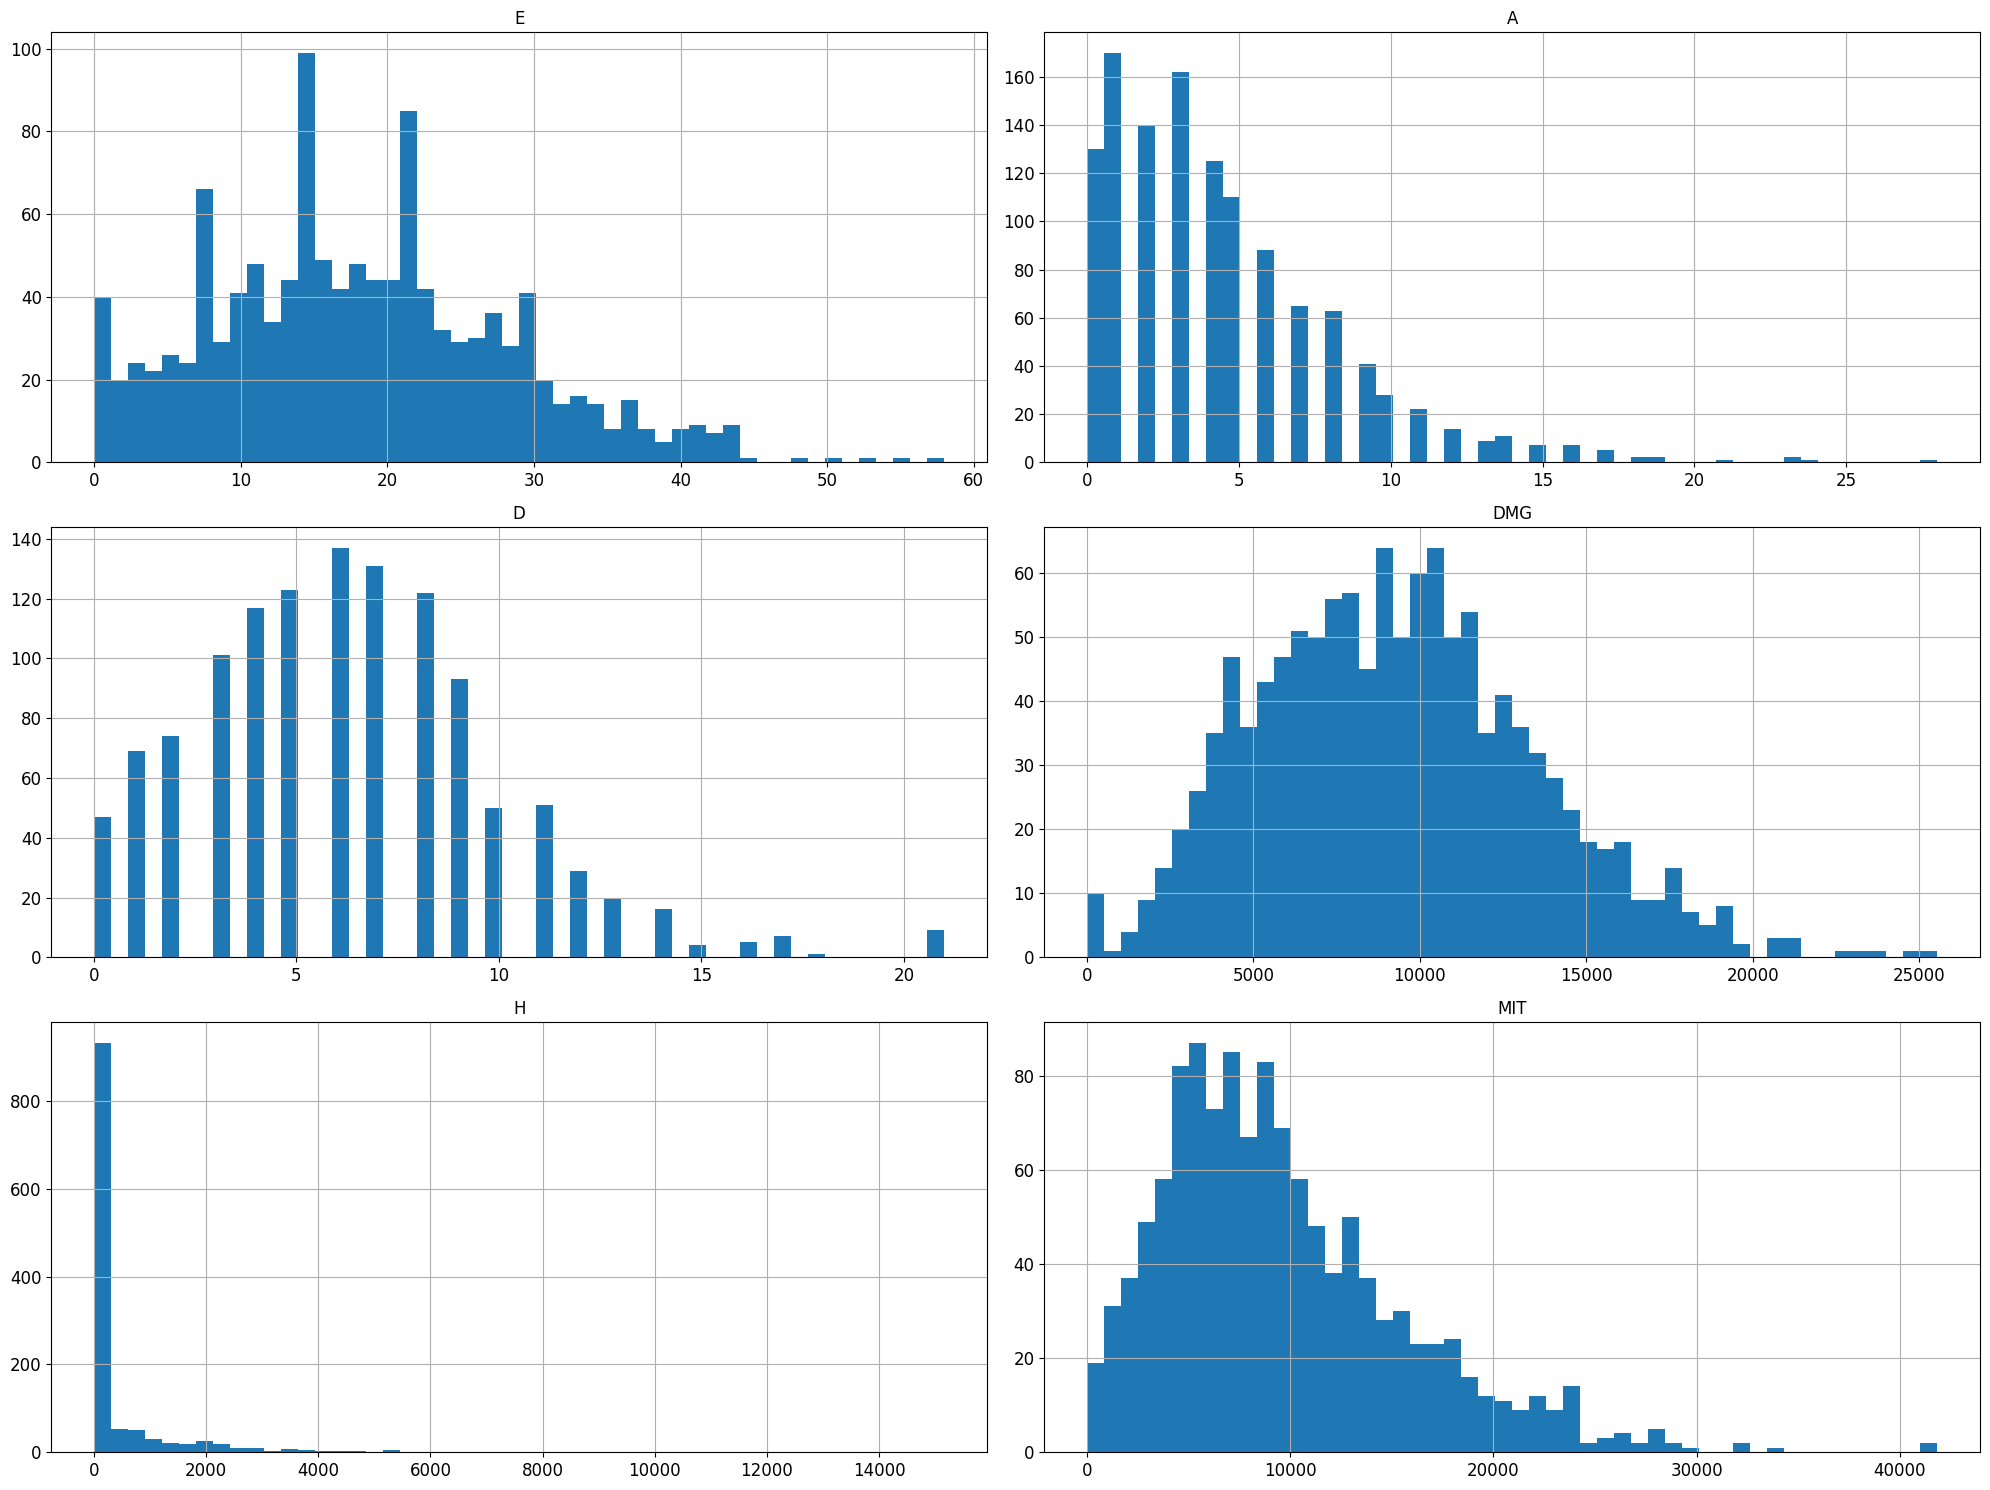

In [10]:
tank.hist(bins=50, figsize=(20, 15))
save_fig('tank_hist')
plt.show()

그림 저장:damage_hist


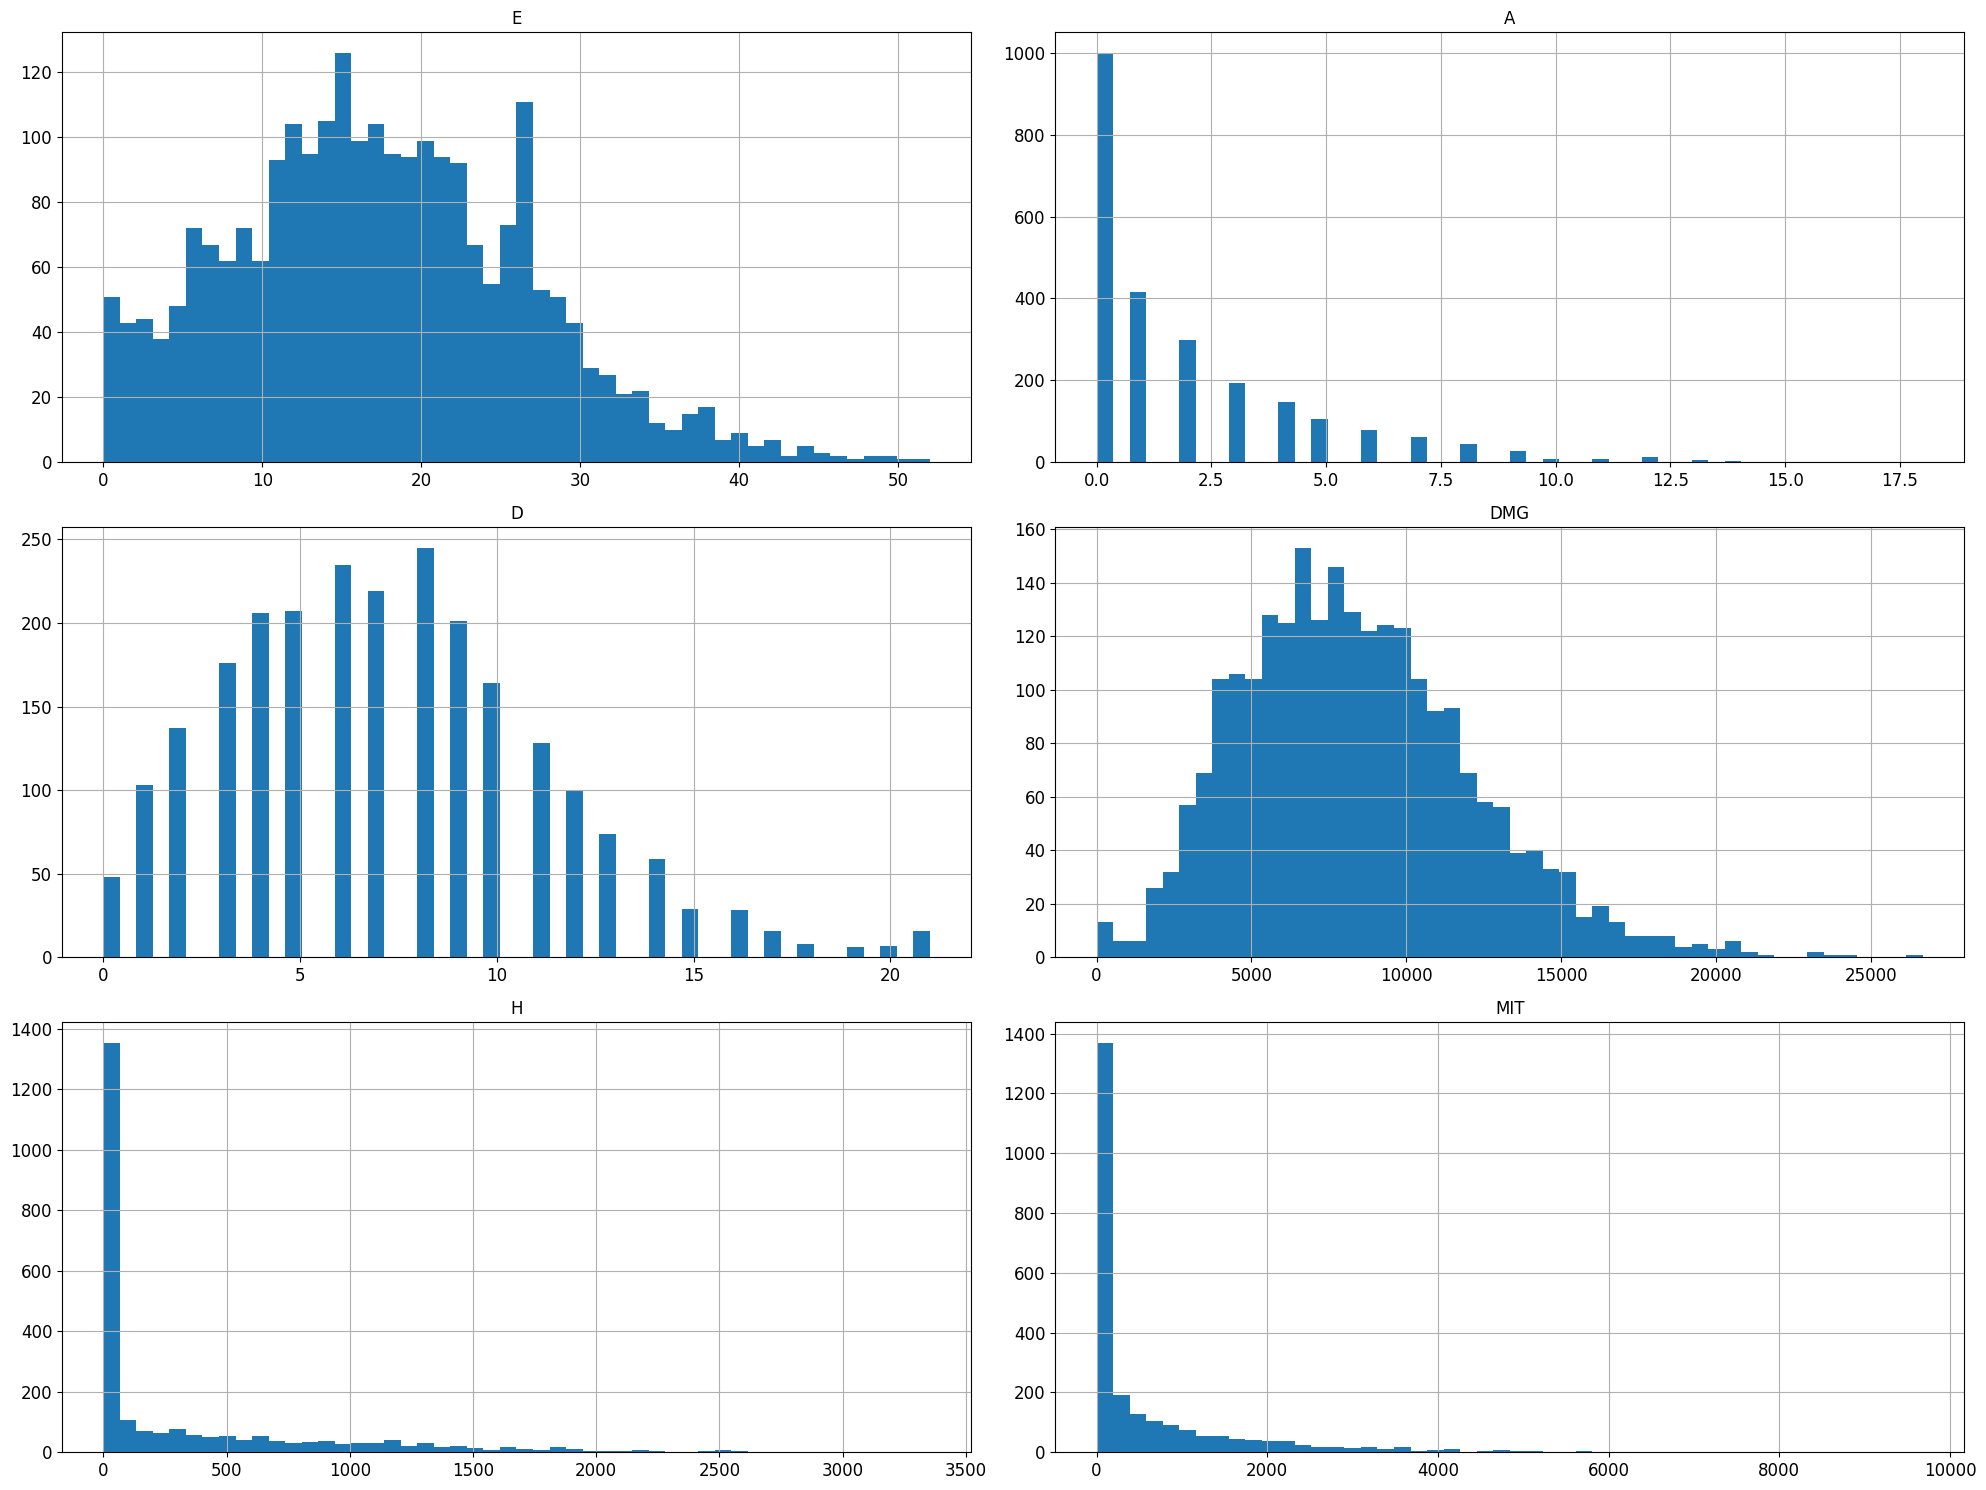

In [11]:
damage.hist(bins=50, figsize=(20, 15))
save_fig('damage_hist')
plt.show()

그림 저장:support_hist


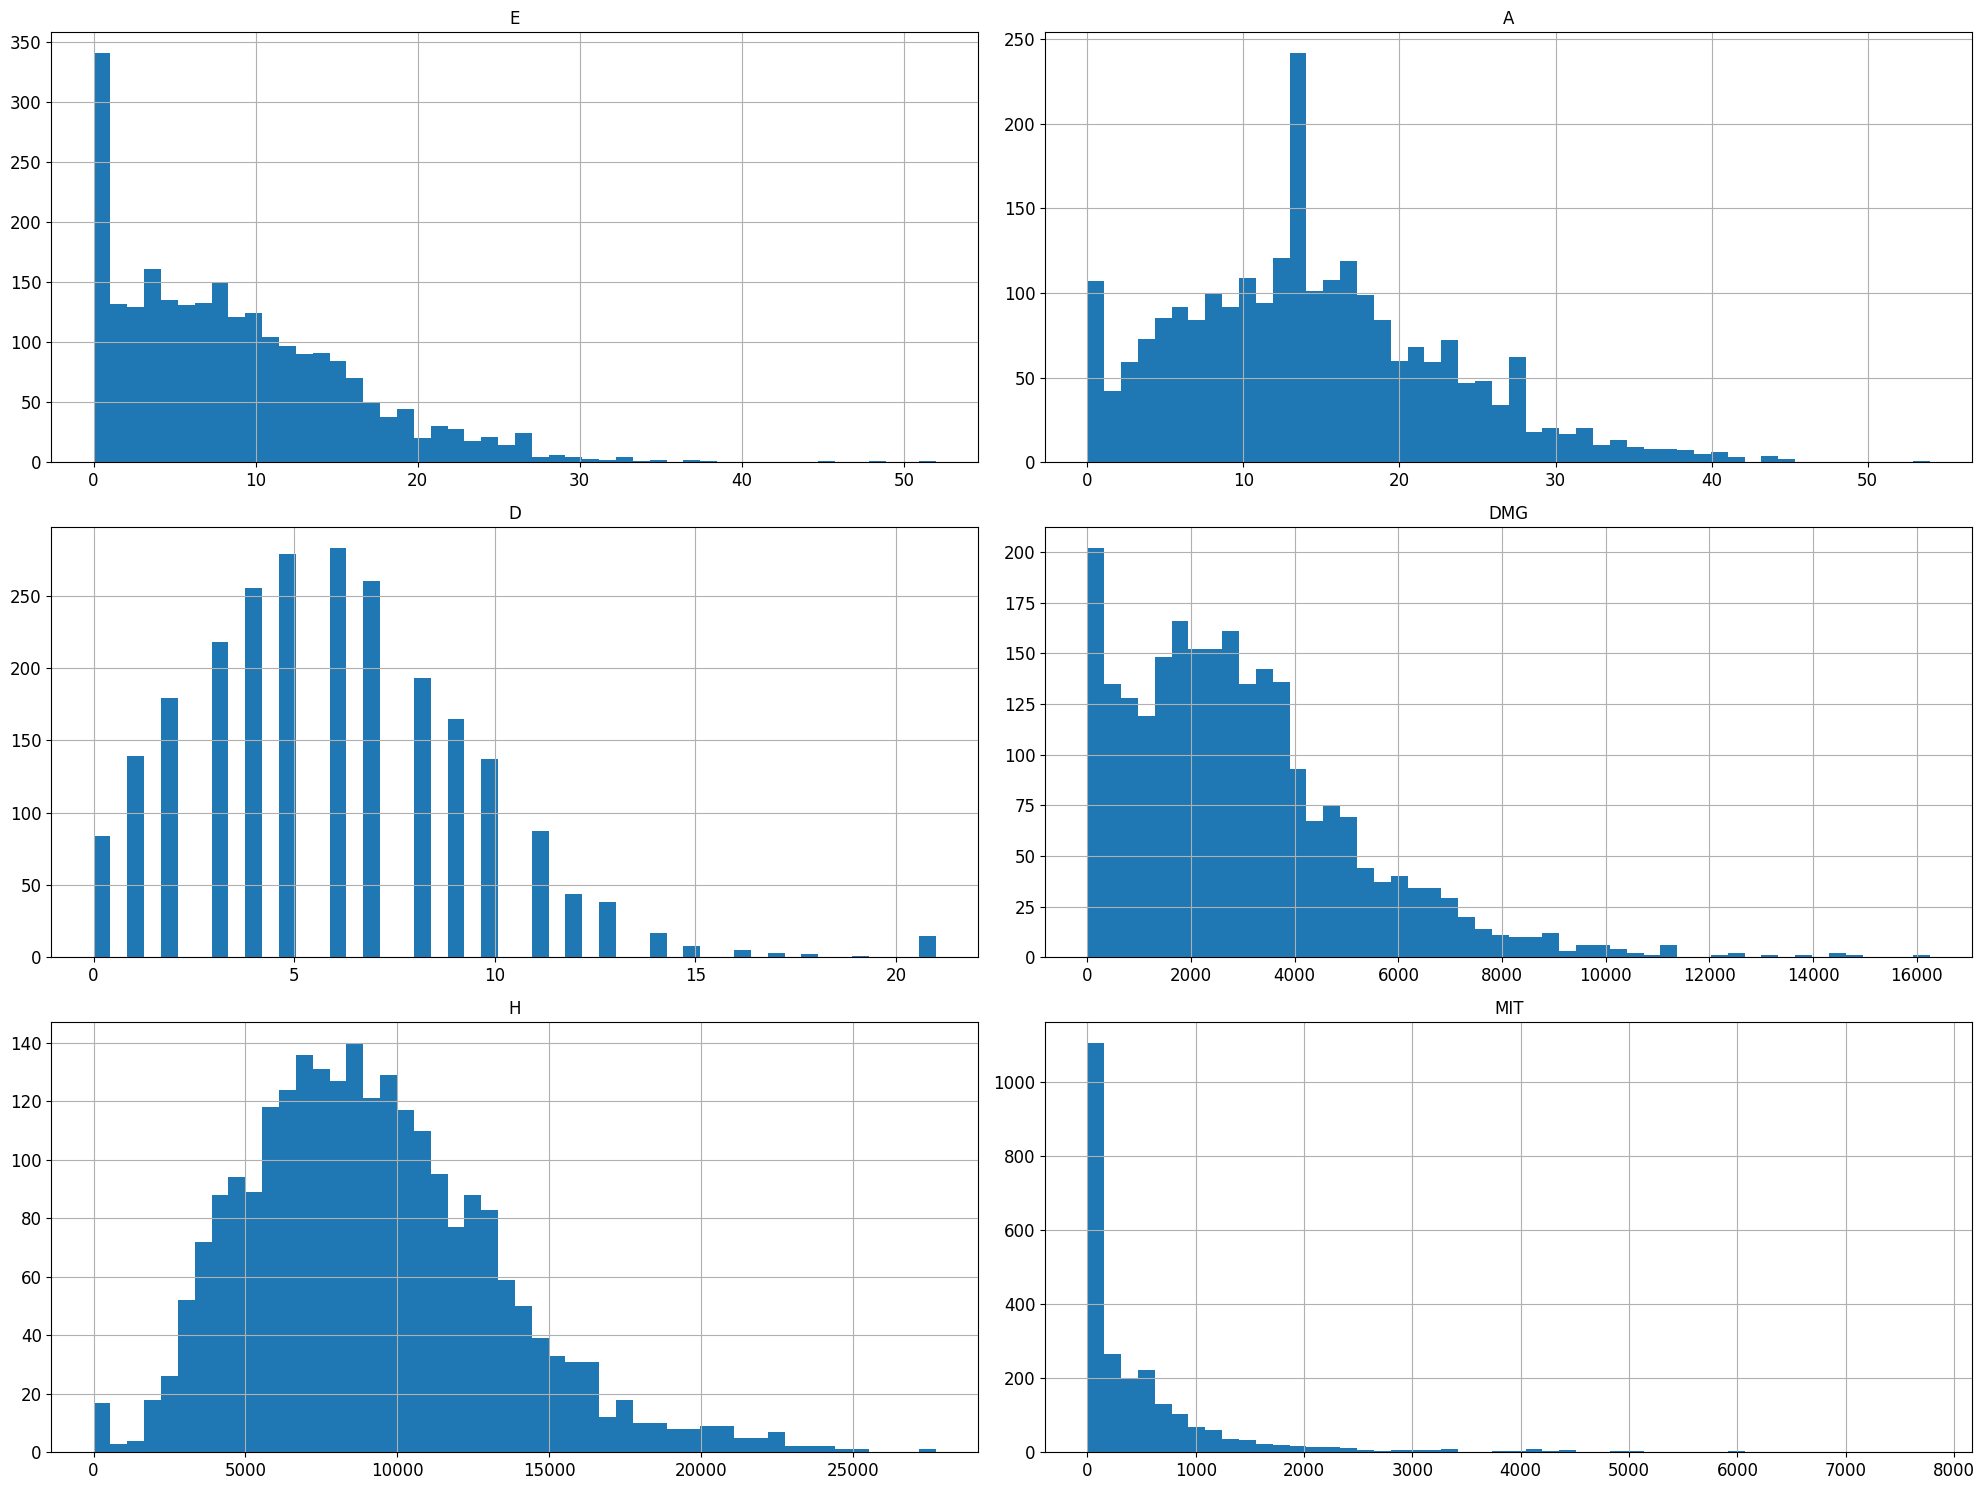

In [12]:
support.hist(bins=50, figsize=(20, 15))
save_fig('support_hist')
plt.show()

In [13]:
from sklearn import utils

scoreboards = scoreboards.loc[utils.shuffle(range(len(scoreboards.index) // players))]
scoreboards

E   A  D   DMG     H    MIT     GAME
367 0  15   2  5  8310     0  14974  VICTORY
    1  18   0  3  5077     0      0  VICTORY
    2  25   1  4  9539     0     27  VICTORY
    3  12  12  5  2306  6034    734  VICTORY
    4   3  24  4   961  8298      0  VICTORY
...    ..  .. ..   ...   ...    ...      ...
17  5   8   3  6  5869     0   2888  VICTORY
    6   7   0  7  6471   151    137  VICTORY
    7   7   0  8  7759  1389      0  VICTORY
    8   3   7  4  1734  7456    228  VICTORY
    9  11   9  3  4170  9202   4984  VICTORY

[6030 rows x 7 columns]

In [14]:
X = scoreboards.drop('GAME', axis=1)
y = scoreboards['GAME'][::players].copy()

In [15]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler().fit(X)
joblib.dump(scaler, 'scaler.joblib')
X = pd.DataFrame(scaler.transform(X), X.index, X.columns)
X

E         A         D       DMG         H       MIT
367 0  0.258621  0.037037  0.238095  0.311633  0.000000  0.357810
    1  0.310345  0.000000  0.142857  0.190392  0.000000  0.000000
    2  0.431034  0.018519  0.190476  0.357721  0.000000  0.000645
    3  0.206897  0.222222  0.238095  0.086477  0.217394  0.017539
    4  0.051724  0.444444  0.190476  0.036038  0.298962  0.000000
...         ...       ...       ...       ...       ...       ...
17  5  0.137931  0.055556  0.285714  0.220093  0.000000  0.069010
    6  0.120690  0.000000  0.333333  0.242669  0.005440  0.003274
    7  0.120690  0.000000  0.380952  0.290970  0.050043  0.000000
    8  0.051724  0.129630  0.190476  0.065027  0.268627  0.005448
    9  0.189655  0.166667  0.142857  0.156379  0.331532  0.119095

[6030 rows x 6 columns]

In [16]:
features = X.shape[-1]
total_features = players * features
X = X.values.reshape(-1, total_features)
print(X.shape)
print(y.shape)

(603, 60)
(603,)


In [17]:
from sklearn import model_selection, linear_model

cv_iter = 1600
model_selection.cross_val_score(linear_model.LogisticRegressionCV(max_iter=cv_iter), X, y)

array([0.92561983, 0.92561983, 0.90082645, 0.90833333, 0.91666667])

In [18]:
from sklearn import neighbors

radius = 2.
model_selection.cross_val_score(neighbors.RadiusNeighborsClassifier(radius), X, y)

array([0.54545455, 0.54545455, 0.57024793, 0.59166667, 0.55      ])

In [19]:
from sklearn import neural_network

classifier_iter = 3200
model_selection.cross_val_score(neural_network.MLPClassifier(max_iter=classifier_iter), X, y)

array([0.90909091, 0.8677686 , 0.85950413, 0.875     , 0.90833333])

In [20]:
from sklearn import ensemble, svm, tree
import operator

estimators = (
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(n_jobs=-1),
    ensemble.ExtraTreesClassifier(n_jobs=-1),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(n_jobs=-1),
    ensemble.HistGradientBoostingClassifier(),
    linear_model.LogisticRegression(n_jobs=-1),
    linear_model.LogisticRegressionCV(max_iter=cv_iter, n_jobs=-1),
    linear_model.PassiveAggressiveClassifier(n_jobs=-1),
    linear_model.Perceptron(n_jobs=-1),
    linear_model.RidgeClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(n_jobs=-1),
    neighbors.KNeighborsClassifier(n_jobs=-1),
    neighbors.RadiusNeighborsClassifier(radius, n_jobs=-1),
    neighbors.NearestCentroid(),
    neural_network.MLPClassifier(max_iter=classifier_iter),
    svm.LinearSVC(dual='auto'),
    svm.NuSVC(),
    svm.SVC(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier()
)
scores = [(estimator, model_selection.cross_val_score(estimator, X, y, n_jobs=-1).mean()) for estimator in estimators]
scores.sort(key=operator.itemgetter(1), reverse=True)
scores

[(LogisticRegressionCV(max_iter=1600, n_jobs=-1), 0.9154132231404958),
 (NearestCentroid(), 0.9137878787878788),
 (RidgeClassifierCV(), 0.9137603305785124),
 (NuSVC(), 0.9121212121212121),
 (RidgeClassifier(), 0.9087878787878788),
 (LinearSVC(dual='auto'), 0.9087878787878788),
 (LogisticRegression(n_jobs=-1), 0.9087741046831956),
 (SVC(), 0.9071349862258954),
 (ExtraTreesClassifier(n_jobs=-1), 0.9054820936639117),
 (HistGradientBoostingClassifier(), 0.9004683195592287),
 (RandomForestClassifier(n_jobs=-1), 0.8955096418732783),
 (MLPClassifier(max_iter=3200), 0.8922176308539946),
 (GradientBoostingClassifier(), 0.8872314049586777),
 (KNeighborsClassifier(n_jobs=-1), 0.882258953168044),
 (Perceptron(n_jobs=-1), 0.8772176308539945),
 (PassiveAggressiveClassifier(n_jobs=-1), 0.875702479338843),
 (SGDClassifier(n_jobs=-1), 0.872245179063361),
 (AdaBoostClassifier(), 0.8606749311294767),
 (BaggingClassifier(n_jobs=-1), 0.84900826446281),
 (DecisionTreeClassifier(), 0.7992975206611571),
 (Ext

In [21]:
defeats = len(defeat) // players


def find_file(index):
    index += 1
    if index <= defeats:
        return f'DEFEAT ({index})'
    else:
        index -= len(victory) // players
        return f'VICTORY ({index})'

In [22]:
for estimator, _ in scores:
    estimator = estimator.fit(X, y)
    if hasattr(estimator, 'feature_importances_'):
        importances = estimator.feature_importances_.reshape(-1, features)
        tanks, damages, supports = [0, 5], [1, 2, 6, 7], [3, 4, 8, 9]
        importances_tank = importances[tanks].sum(0)
        importances_damage = importances[damages].sum(0)
        importances_support = importances[supports].sum(0)
        importances[tanks] = importances_tank / 2
        importances[damages] = importances_damage / 4
        importances[supports] = importances_support / 4
        joblib.dump(importances, 'importances.joblib')

        titles = '처치', '도움', '죽음', '피해', '치유', '경감'

        print('**특성 중요도**')
        for importance, title in sorted(zip(importances.sum(0), titles), reverse=True):
            print(f'{title}: {importance:.2f}')

        print('\n**1인 역할 중요도**')
        for importance, title in sorted(
                zip(
                    (importances_tank.sum(), importances_damage.sum() / 2, importances_support.sum() / 2),
                    ('돌격', '공격', '지원')
                ),
                reverse=True
        ):
            print(f'{title}: {importance:.2f}')

        print('\n**1인 돌격 특성 중요도**')
        for importance, title in sorted(zip(importances_tank, titles), reverse=True):
            print(f'{title}: {importance:.2f}')

        print('\n**1인 공격 특성 중요도**')
        for importance, title in sorted(zip(importances_damage / 2, titles), reverse=True):
            print(f'{title}: {importance:.2f}')

        print('\n**1인 지원 특성 중요도**')
        for importance, title in sorted(zip(importances_support / 2, titles), reverse=True):
            print(f'{title}: {importance:.2f}')

        break

**특성 중요도**
처치: 0.32
죽음: 0.28
도움: 0.19
피해: 0.08
치유: 0.07
경감: 0.06

**1인 역할 중요도**
돌격: 0.27
지원: 0.20
공격: 0.17

**1인 돌격 특성 중요도**
처치: 0.09
죽음: 0.09
도움: 0.04
피해: 0.02
경감: 0.01
치유: 0.01

**1인 공격 특성 중요도**
처치: 0.08
죽음: 0.04
피해: 0.02
도움: 0.02
치유: 0.01
경감: 0.01

**1인 지원 특성 중요도**
도움: 0.06
죽음: 0.06
처치: 0.04
치유: 0.01
피해: 0.01
경감: 0.01


In [23]:
defeats = defeat.index.stop
for i in range(defeats - 10, defeats - 101, -players):
    defeat_i = defeat[i:i + players]
    print(f'DEFEAT ({i // players + 1})')
    print(defeat_i)
    contributions = scaler.transform(defeat_i.drop(['GAME'], axis=1))
    contributions[:, 2] = 1 - contributions[:, 2]
    contributions *= importances
    contributions = contributions.sum(1)
    contributions[tanks] *= 2 / contributions[tanks].sum()
    contributions[damages] *= 4 / contributions[damages].sum()
    contributions[supports] *= 4 / contributions[supports].sum()
    print(f'TEAM 1:', end='')
    for contribution in contributions[:5]:
        print(f' {contribution:.2f}', end='')
    print(f'\nTEAM 2:', end='')
    for contribution in contributions[5:]:
        print(f' {contribution:.2f}', end='')
    print('\n')

DEFEAT (279)
       E   A   D    DMG     H   MIT     GAME
2780  14   6  10   8927     0  8715   DEFEAT
2781  17   0  19   9104     0   757   DEFEAT
2782  18   0   5  11141     0   122   DEFEAT
2783   4  15  13   1949  6872     0   DEFEAT
2784   8  10  13   3768  8238   200   DEFEAT
2785  33  16   4   8813     0  6471  VICTORY
2786  30   8   6   9562     0   174  VICTORY
2787  36  12   8  10867   429     0  VICTORY
2788  22  11   5   5843  9202    72  VICTORY
2789  19  23   5   4813  8285   334  VICTORY
TEAM 1: 0.73 0.52 0.96 0.71 0.69
TEAM 2: 1.27 1.21 1.31 1.21 1.38

DEFEAT (278)
       E   A  D   DMG     H    MIT     GAME
2770   6   1  8  4507   665  10484   DEFEAT
2771   7   0  4  4528     0     83   DEFEAT
2772   6   0  7  4209     0     40   DEFEAT
2773   5   8  4  1758  6765      0   DEFEAT
2774   4   7  6  2944  6271      0   DEFEAT
2775  14   2  2  8923     0   4241  VICTORY
2776  14   1  1  7844     0    127  VICTORY
2777  17   0  4  4720     0    563  VICTORY
2778  14  18  1 

In [24]:
victorys = victory.index.stop
for i in range(victorys - 10, victorys - 101, -players):
    victory_i = victory[i:i + players]
    print(f'VICTORY ({i // players + 1})')
    print(victory_i)
    contributions = scaler.transform(victory_i.drop(['GAME'], axis=1))
    contributions[:, 2] = 1 - contributions[:, 2]
    contributions *= importances
    contributions = contributions.sum(1)
    contributions[tanks] *= 2 / contributions[tanks].sum()
    contributions[damages] *= 4 / contributions[damages].sum()
    contributions[supports] *= 4 / contributions[supports].sum()
    print(f'TEAM 1:', end='')
    for contribution in contributions[:5]:
        print(f' {contribution:.2f}', end='')
    print(f'\nTEAM 2:', end='')
    for contribution in contributions[5:]:
        print(f' {contribution:.2f}', end='')
    print('\n')

VICTORY (324)
       E   A   D    DMG      H    MIT     GAME
3230  31  13  12  17878   1828  17526  VICTORY
3231  31   3  10  14888      0    865  VICTORY
3232  27   5  16  12055   1815    158  VICTORY
3233  23  18  11  10404  14724    270  VICTORY
3234  30  23  11  13943  21616      0  VICTORY
3235  32   6  11  17654    712  15617   DEFEAT
3236  43  12   6  15130    220      0   DEFEAT
3237  44   6  11  24353      0      0   DEFEAT
3238  18  37   9   5889  17723    243   DEFEAT
3239  24  26  10   8749  20264   3243   DEFEAT
TEAM 1: 1.00 0.90 0.69 0.85 1.02
TEAM 2: 1.00 1.22 1.18 1.11 1.02

VICTORY (323)
       E   A   D    DMG      H    MIT     GAME
3220  29  11   6  13638      0  13498  VICTORY
3221  28   0   4  14549      0    224  VICTORY
3222  37   0   3  14422      0      0  VICTORY
3223  33  22   8  13205  12729      0  VICTORY
3224  15  35   5   4037  15688   1016  VICTORY
3225   7   3  13  13279      0   7272   DEFEAT
3226  15   0  12   7280      0   1049   DEFEAT
3227  20   0

In [25]:
from tensorflow.keras import backend, layers
from tensorflow import keras

backend.clear_session()
model = keras.Sequential()
model.add(layers.Dense(300, 'relu', input_shape=(total_features,)))
model.add(layers.Dense(100, 'relu'))
model.add(layers.Dense(1, 'sigmoid'))
model.summary()

2024-03-04 16:47:06.221612: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 16:47:07.424100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 16:47:07.440996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 16:47:07.441265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been bu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               18300     
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 48501 (189.46 KB)
Trainable params: 48501 (189.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
from tensorflow.keras import optimizers, callbacks

model.compile('sgd', 'binary_crossentropy', ['accuracy'])
transform = preprocessing.LabelEncoder().fit_transform(y)
stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X,
    transform,
    epochs=256,
    callbacks=[stopping],
    validation_split=.25
)
history.history['val_loss'][-11], history.history['val_accuracy'][-11]

Epoch 1/256


2024-03-04 16:47:08.360459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-04 16:47:08.375708: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa4e4c3cf90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-04 16:47:08.375750: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-03-04 16:47:08.394596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-03-04 16:47:08.408097: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-04 16:47:08.448187: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 1s 13ms/step - loss: 0.6957 - accuracy: 0.4690 - val_loss: 0.6758 - val_accuracy: 0.6093
Epoch 2/256
15/15 [==============================] - 0s 5ms/step - loss: 0.6765 - accuracy: 0.6637 - val_loss: 0.6634 - val_accuracy: 0.8609
Epoch 3/256
15/15 [==============================] - 0s 5ms/step - loss: 0.6630 - accuracy: 0.8407 - val_loss: 0.6534 - val_accuracy: 0.8609
Epoch 4/256
15/15 [==============================] - 0s 5ms/step - loss: 0.6518 - accuracy: 0.8496 - val_loss: 0.6444 - val_accuracy: 0.7815
Epoch 5/256
15/15 [==============================] - 0s 5ms/step - loss: 0.6416 - accuracy: 0.7765 - val_loss: 0.6354 - val_accuracy: 0.7748
Epoch 6/256
15/15 [==============================] - 0s 5ms/step - loss: 0.6328 - accuracy: 0.7854 - val_loss: 0.6287 - val_accuracy: 0.6821
Epoch 7/256
15/15 [==============================] - 0s 5ms/step - loss: 0.6244 - accuracy: 0.7367 - val_loss: 0.6194 - val_accuracy: 0.7351
Epoch 8/256
15/15 [=====

(0.18221864104270935, 0.9205297827720642)